In [1]:
# libraries
from customCLIP import customCLIP
import pandas as pd

/usr/local/Caskroom/miniconda/base/envs/EuroSAT/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FEW_SHOT = 8
MODE = "coop"
IMAGE_PATH = "2750/Forest/Forest_109.jpg"

customclip = customCLIP(model_name="openai/clip-vit-base-patch32")

if MODE == "coop":
    model_path = f"models/prompt_learners/coop/{FEW_SHOT}_shot.pth"
    customclip.load_model(model_path, mode=MODE)
elif MODE in ["linear_probe", "MLP_probe", "logreg_probe"]:
    model_path = f"results/classifiers/{MODE}/{FEW_SHOT}-shot"
    customclip.load_model(model_path, mode=MODE)
elif MODE == "zeroshot":
    pass

customclip.set_testing_mode(MODE)
prediction, prob, _ = customclip.classify_images_clip([IMAGE_PATH])
print(prediction.item(), prob.item())
# print(customclip.class_labels[prediction.item()])

Loaded coop model from models/prompt_learners/coop/8_shot.pth
Testing in coop mode
1 0.9504203796386719


In [108]:
customclip = customCLIP(model_name="openai/clip-vit-base-patch32", full_prompt=True, modify=True,augment_hue=True)
# customclip.load_model("models/classifiers/linear_probe/16-shot.pth", mode="linear_probe")
# results = customclip.train(few_shot=8, mode="CoOp", save_model=False)
customclip.train(few_shot=4, mode="linear_probe", save_model=True)


Training linear probe with 4-shot data...
Epoch [0/1000] | Train Loss: 2.2846 | Val Loss 2.2713 | Val Acc: 13.80%
Epoch [250/1000] | Train Loss: 0.0705 | Val Loss 0.8862 | Val Acc: 72.40%
Epoch [500/1000] | Train Loss: 0.0235 | Val Loss 0.8545 | Val Acc: 72.40%
Epoch [750/1000] | Train Loss: 0.0123 | Val Loss 0.8535 | Val Acc: 72.20%
Epoch [1000/1000] | Train Loss: 0.0076 | Val Loss 0.8585 | Val Acc: 72.20%
linear_probe model saved at models/classifiers/linear_probe/4-shot.pth


In [111]:
customclip = customCLIP(model_name="openai/clip-vit-base-patch32", full_prompt=True, modify=True,augment_hue=True)

customclip.load_model("models/prompt_learners/coop/4_shot.pth", mode="coop")

customclip.set_testing_mode("coop")
results = customclip.multi_class_analysis()
results.to_csv("results/coop/4_shot")

Loaded coop model from models/prompt_learners/coop/4_shot.pth
Testing in coop mode
Testing dataset using coop method


Classifying SeaLake batches: 100%|██████████| 47/47 [00:19<00:00,  2.45it/s]


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def classifiers_accuracies(mode, path):
    
    # Define few-shot settings
    few_shot_settings = [1, 2, 4, 8, 16]

    # Load results into a dictionary
    accuracy_per_class = {}

    for few_shot in few_shot_settings:
        results_df = pd.read_csv(f"{path}/{few_shot}-shot")
        accuracy_per_class[few_shot] = list(results_df.accuracy)  # Assuming accuracy is per class

        average_few_shot_accuracy = results_df.accuracy.mean()
        accuracy_per_class[few_shot].insert(0, average_few_shot_accuracy)
    
    CLASSES = results_df["class"].tolist()

    # Prepare the x positions
    x = np.arange(len(CLASSES) + 1)  # Add one for the "Average" bar

    plt.figure(figsize=(20, 5))

    # Bar widths
    bar_width = 0.15

    # Plot each few-shot setting with adjusted positions
    plt.bar(x - 2 * bar_width, accuracy_per_class[1], width=bar_width, label="1-shot", alpha=0.7)
    plt.bar(x - bar_width, accuracy_per_class[2], width=bar_width, label="2-shot", alpha=0.7)
    plt.bar(x, accuracy_per_class[4], width=bar_width, label="4-shot", alpha=0.7)
    plt.bar(x + bar_width, accuracy_per_class[8], width=bar_width, label="8-shot", alpha=0.7)
    plt.bar(x + 2 * bar_width, accuracy_per_class[16], width=bar_width, label="16-shot", alpha=0.7)

    plt.xticks(x, ["Average"] + CLASSES, rotation=45, ha="right")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{mode} Comparison of Class Accuracies")
    plt.legend()
    plt.show()

    return accuracy_per_class

# Call the function with a specific mode


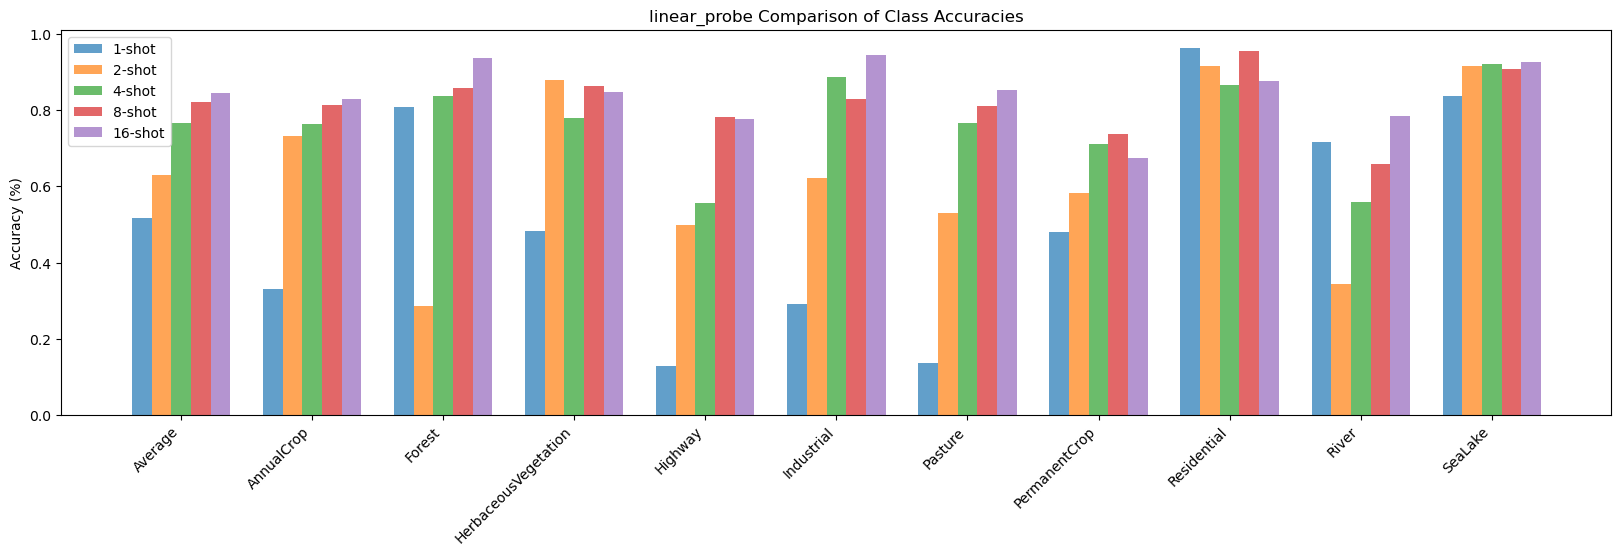

In [89]:
_ = classifiers_accuracies('linear_probe', "results/classifiers/linear_probe")

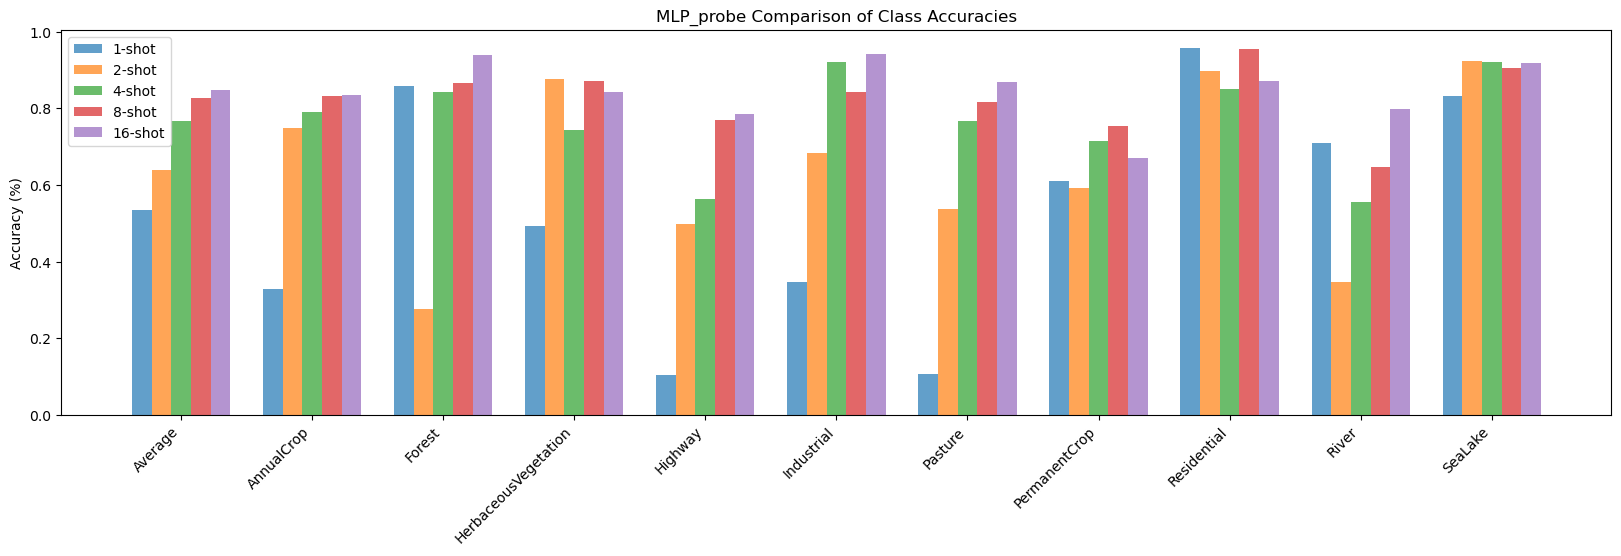

In [88]:
_ = classifiers_accuracies("MLP_probe", "results/classifiers/MLP_probe")

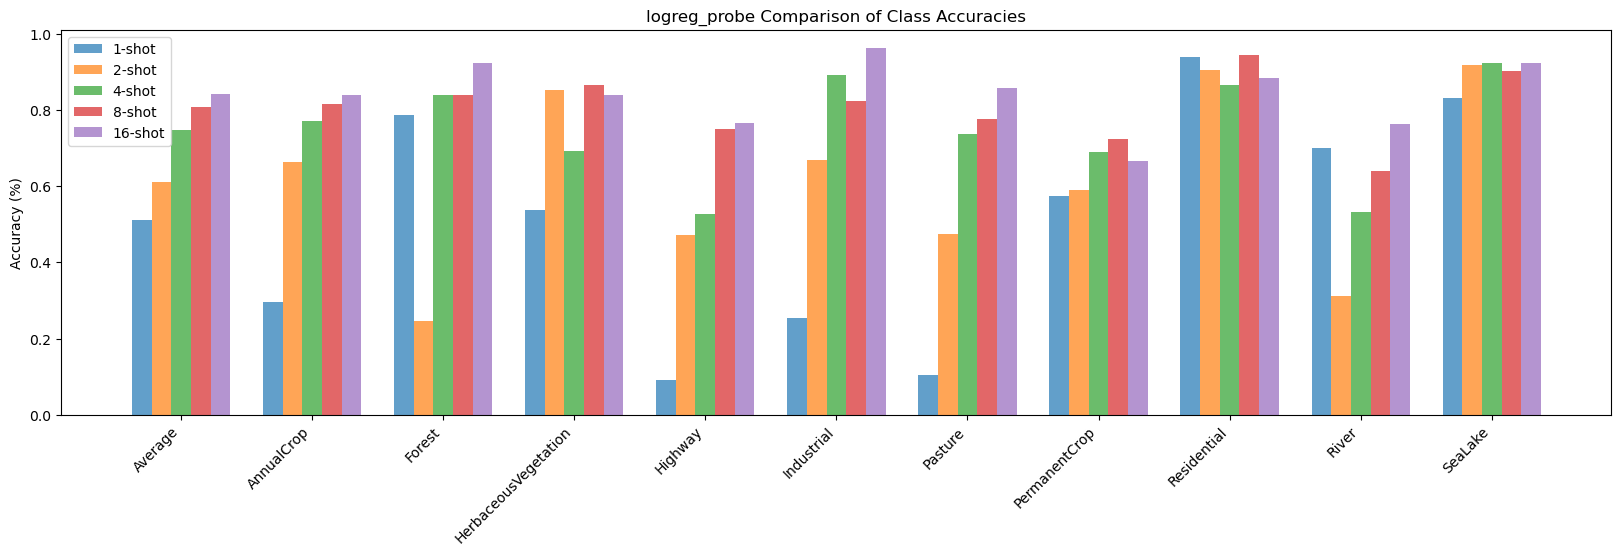

In [91]:
_ = classifiers_accuracies("logreg_probe", "results/classifiers/logreg_probe")

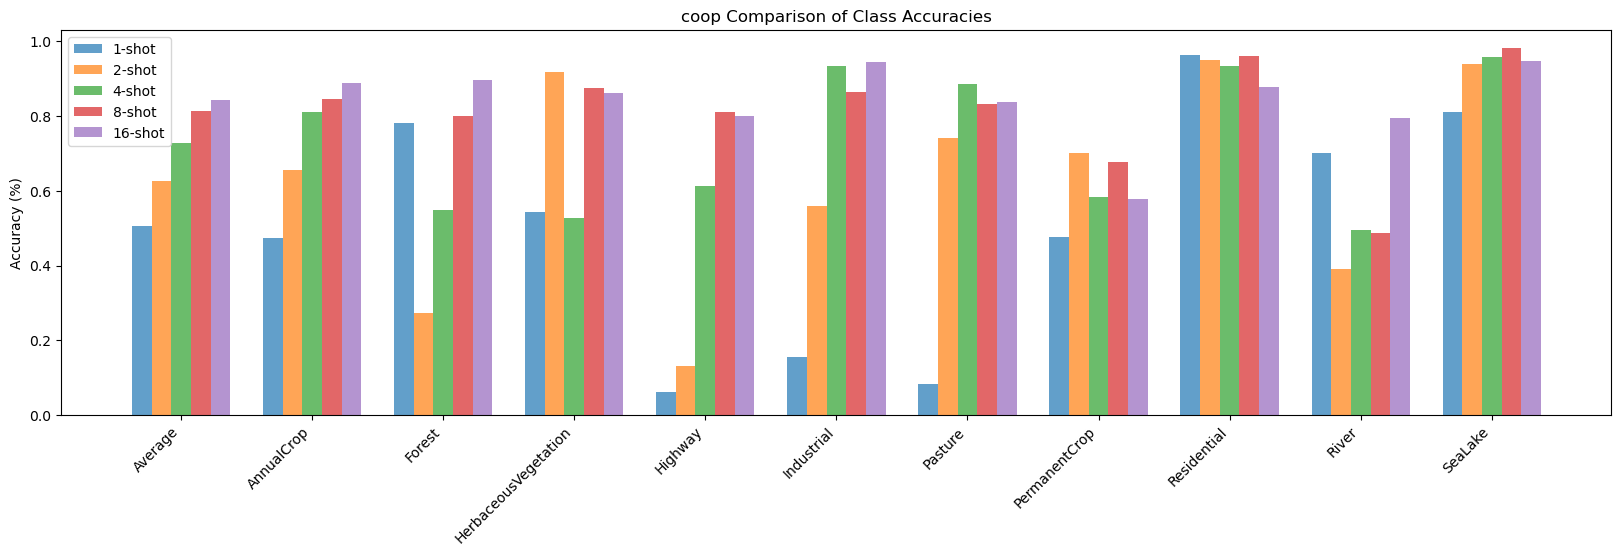

In [98]:
_ = classifiers_accuracies("coop", "results/coop")

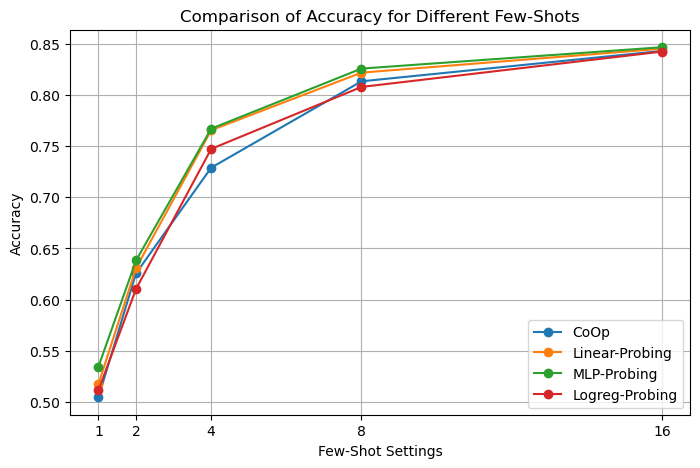

In [114]:
few_shot_settings = [1, 2, 4, 8, 16]

# Load results into a dictionary
accuracy_per_class = {}

for few_shot in few_shot_settings:
    coop_results_df = pd.read_csv(f"results/coop/{few_shot}-shot")
    linear_results_df = pd.read_csv(f"results/classifiers/linear_probe/{few_shot}-shot")
    mlp_results_df = pd.read_csv(f"results/classifiers/mlp_probe/{few_shot}-shot")
    logreg_results_df = pd.read_csv(f"results/classifiers/logreg_probe/{few_shot}-shot")

    accuracy_per_class[few_shot] = [coop_results_df.accuracy.mean(), linear_results_df.accuracy.mean(), mlp_results_df.accuracy.mean(), logreg_results_df.accuracy.mean()]

# Extracting keys and values for plotting
x = list(accuracy_per_class.keys())
y_values = list(zip(*accuracy_per_class.values()))  # Transposing the values to separate the two series

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(x, y_values[0], label="CoOp", marker='o')
plt.plot(x, y_values[1], label="Linear-Probing", marker='o')
plt.plot(x, y_values[2], label="MLP-Probing", marker='o')
plt.plot(x, y_values[3], label="Logreg-Probing", marker='o')

plt.xlabel("Few-Shot Settings")
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy for Different Few-Shots")
plt.legend()
plt.grid(True)
plt.xticks(x)

plt.show()
